# Load fundamental modules & initialize variables

In [1]:
# Standard library imports
from collections import OrderedDict as od
from glob import glob
from importlib import reload
import inspect
import itertools
import os
import os.path as op
import random
import sys
from time import time
import warnings

# Third party imports
import cv2 as cv2
import h5py
import matplotlib as mpl # plotting
from matplotlib.lines import Line2D # plotting
import matplotlib.patches as patches # plotting 
import matplotlib.pyplot as plt # plotting
import matplotlib.gridspec as gridspec  # plotting
import numpy as np # functions to analyze and manipulate arrays & matrices
import pandas as pd # dataframes
import scipy.interpolate as interp # scientific computation 
import scipy.io as sio # scientific computation 
import scipy.stats as stats # scientific computation 
import scipy.ndimage as ndi
from scipy import signal
import seaborn as sns # plotting
from sklearn.decomposition import PCA # tools for machine learning and statistical modeling. Useful for predictions of unobserved values.
import statsmodels.api as sm # tools for statistical analysis. Useful for statistical inference and statistical hypothesis testing.
from statsmodels.formula.api import ols

# Local application imports
sys.path.append('/home1/cjmac/code/general')
sys.path.append('/home1/cjmac/code/manning_replication')
sys.path.append('/home1/cjmac/code/projects/')
import array_operations as aop # for coding
import data_io as dio # for coding
from eeg_plotting import plot_trace, plot_trace2 #plotting
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, trial_phase_analysis # processing eeg data

# Initializing commands
%matplotlib inline
warnings.filterwarnings( 'ignore' )
pd.options.display.max_rows = 500
pd.options.display.max_columns = 999

# Plotting parameters
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42
# warnings.filterwarnings( 'default' )

# Plotting colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)
# Plotting font
font = {'tick': 12,
        'label': 14,
        'fig': 16}

In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

## Perform alignment (or not)

In [2]:
subj_sess = 'U540_ses0'

# Load the sync channel.
# sync_chan = events_preproc.load_syncs(subj_sess, data_key='data')
sync_chan, TTL, timestamp_flag = events_preproc.load_syncs(subj_sess, data_key='data')

In [3]:
if not timestamp_flag: 
     
    # Read events file and get event synctimes.
    events, event_synctimes = events_preproc.read_events_json(subj_sess)

    # Load LFP timestamps. LFP timestamps must be in msec
    lfp_timestamps, sr = spike_sorting.load_lfp_timestamps(subj_sess, start_at_zero=False)

    # Identify sync pulses in the sync channel EEG. The sync channel EEG is typically sampled at a different rate than the physiological EEG.
    pulse_startinds = events_preproc.find_pulse_starts(sync_chan, 
                                                       sampling_rate=sr, 
                                                       pulse_thresh=200, 
                                                       intrapulse_thresh_ms=20, 
                                                       interpulse_thresh_ms=790
                                                      )
    
    lfp_synctimes = lfp_timestamps[pulse_startinds]
    
    print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

    subj, sess = subj_sess.split('_')
    sync_f = os.path.join('/home1/cjmac/projects/time_cells', 'data', subj, sess, 'sync', 'sync_channel_micro.mat')


    # Find matching sync pulse pairs.
    event_synctimes_adj, lfp_synctimes_adj = events_preproc.pair_sync_pulses(event_synctimes, 
                                                                             lfp_synctimes, 
                                                                             step=5, 
                                                                             max_shift=200, 
                                                                             max_slide=50, 
                                                                             ipi_thresh=2
                                                                            )
    # Perform the alignment.
    alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                                 lfp_synctimes_adj)
    
    # Apply the alignment to all event times.
    events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x))    
    
    flag_plot = 1     
    if (flag_plot):
        # How did our alignment go?
        print('{} event sync pulses'.format(len(event_synctimes_adj)))
        print('{} LFP sync pulses identified'.format(len(lfp_synctimes_adj)))
        print('\n--------------------\nAlignment parameters\n--------------------')
        for k, v in alignment.items():
            print('{}: {}'.format(k, v))

        plt.close()
        fig, ax = plt.subplots(1, 3, figsize=(16, 6), dpi=300)
        ax = np.ravel(ax)

        min_syncs = np.min((len(event_synctimes_adj), len(lfp_synctimes_adj)))
        start = 0
        stop = None

        i = 0
        ax[i].scatter(np.diff(event_synctimes_adj), np.diff(lfp_synctimes_adj))
        ax[i].set_xlabel('$Event_{IPI}$', fontsize=font['label'], labelpad=8)
        ax[i].set_ylabel('$LFP_{IPI}$', fontsize=font['label'], labelpad=8)
        ax[i].set_title('Inter-pulse interval correlation', fontsize=font['fig'], y=1.05)

        i = 1
        ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
        ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
        ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
        ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
        ax[i].set_title('$LFP_{IPI} - Event_{IPI}$', fontsize=font['fig'], y=1.05)

        i = 2
        ax[i].plot(lfp_synctimes_adj[start:stop] - event_synctimes_adj[start:stop])
        ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
        ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
        ax[i].set_title('LFP - Event synctimes', fontsize=font['fig'], y=1.05)

        for i in range(len(ax)):
            ax[i].tick_params(axis='both', which='major', labelsize=font['tick'])
        fig.tight_layout()

        event_synctimes = events.loc[events['key']=='syncPulse', 'time'].values
        event_pulse_inds = (np.array([x for x in (event_synctimes-lfp_timestamps[0]) * (sr/1e3) 
                                      if x<len(lfp_timestamps)])).astype(np.int64)
        event_pulse_startinds_train = np.zeros(len(sync_chan))
        event_pulse_startinds_train[event_pulse_inds] = 1

        fig, ax = plot_trace2(sync_chan, spike_dat=event_pulse_startinds_train,
                              start=300, duration=30, nwin=6, x_units='secs', sampling_rate=sr)  
else:    
    # Read events file and get event synctimes in msec.
    events, event_synctimes = events_preproc.read_events_json( subj_sess, start_at_zero = False  )
    
    # Load LFP timestamps in msec
    lfp_timestamps, sr = spike_sorting.load_lfp_timestamps( subj_sess, start_at_zero = True, conv_factor = 'infer' )

    if (False):
        #
        sync_chan_new = sync_chan.copy()
        sync_chan_new *= 1000 ; # converts to msec
        sync_chan_new = sync_chan_new - sync_chan_new[0] #sync_chan_new and sync_chan are shorter in length than lfp_timestamps bc of different sampling frequency
        TTL_new = TTL.copy()
        TTL_new[np.where(TTL != 255)] = 0
        from scipy import interpolate
        f = interpolate.interp1d(sync_chan_new, TTL_new, kind = 'next', fill_value='extrapolate')
        TTL_up = f(lfp_timestamps)

        flag_plot = 0
        if flag_plot:
            ind_range_1 = [ 0, 100000 ] 
            fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=300)
            plt.plot(lfp_timestamps[ slice( ind_range_1[0], ind_range_1[1], 1)], 
                     TTL_up[ slice( ind_range_1[0], ind_range_1[1], 1)],
                     marker = 'o', color = 'blue', linestyle = 'none', markersize = 8 )

        pulse_startinds = np.where(TTL_up == 255)[0] 
        lfp_synctimes = lfp_timestamps[pulse_startinds]
        
        # 
        flag_plot = 0
        if flag_plot:
            time_range = [ 30000, 100000 ] 
            ind_lfp_synctimes = np.where(np.logical_and(lfp_synctimes>=time_range[0], lfp_synctimes<=time_range[1]))
            ind_event_synctimes= np.where(np.logical_and(event_synctimes>=time_range[0], event_synctimes<=time_range[1]))
            fig, ax = plt.subplots(1, 1, figsize=(30, 10), dpi=300)
            plt.plot(lfp_synctimes[ ind_lfp_synctimes ], 
                     np.full( ( 1, len( ind_lfp_synctimes[0] ) ), 255 )[0],
                     marker = 'o', color = 'blue', linestyle = 'none', markersize = 16 ) 
            plt.plot(event_synctimes[ ind_event_synctimes ], 
                     np.full( ( 1, len( ind_event_synctimes[0] ) ), 255 )[0],
                     marker = 'x', color = 'red', linestyle = 'none', mew = 4, markersize = 16 ) 
            plt.show()   
    
    else:
        #
        sync_chan_new = sync_chan.copy()
        sync_chan_new /= 1000  # converts to msec
#         sync_chan_new = sync_chan_new - sync_chan_new[0] # zero the timestamps
        TTL_up = TTL.copy()
        pulse_startinds = np.where(TTL_up == 1)[0] 
        lfp_synctimes = sync_chan_new[pulse_startinds]
        event_synctimes = event_synctimes[2000:]

The first timestamp in events before zero-ing is 1627593194100.360
The first timestamp in events after zero-ing is 0.000
85458 events recorded over 68 min and 52 sec
The first timestamp in lfp_timestamps before zero-ing & before conv factor is 0.000
The first timestamp in lfp_timestamps before zero-ing & after conv factor is 0.000
The first timestamp in lfp_timestamps after zero-ing & conv factor is 0.000
Conversion factor is 1
123945508 timestamps over 68 min and 51.5 s
Sampling rate is 30000 Hz
> /home1/cjmac/code/projects/time_cells/events_preproc.py(167)find_pulse_starts()
-> interpulse_thresh = interpulse_thresh_ms * (sampling_rate / 1000)


(Pdb)  ipis


array([ 7956,   388, 26096, ...,   427, 25521,   396])


(Pdb)  interpulse_thresh_ms


790


(Pdb)  intrapulse_thresh_ms


20


(Pdb)  q


BdbQuit: 

In [67]:
# working on this. 
# requirements: the times must be in msec
# compute the time difference between succesive indices in the event and lfp synctime time series
event_synctimes_diff = np.diff(event_synctimes)
event_synctimes_diff = np.expand_dims(event_synctimes_diff, axis = -1)
lfp_synctimes_diff = np.diff(lfp_synctimes)
lfp_synctimes_diff = np.expand_dims(lfp_synctimes_diff, axis = -1)

# get the difference matrix for all possible combinaiotions of event_synctimes_diff and lfp_synctimes_diff
event_lfp_pairs_diff = event_synctimes_diff - lfp_synctimes_diff.T

# 
event_lfp_pairs_diff_lt = np.array(np.abs(event_lfp_pairs_diff)<2).astype('uint8')

#
kernel = np.eye(4)
img00 = signal.convolve2d(np.array(signal.convolve2d(event_lfp_pairs_diff_lt,kernel,mode='valid') == np.sum(kernel[:])).astype('uint8'),kernel,mode='full') > 0
# convert from boolean ndarray to uint8 type. Should be an array of all zeros and ones
img01 = np.array(img00*255, dtype = np.uint8)
cv2.imwrite('./outputs/images/img01.jpeg', img01)

True

In [68]:
# Read image
image = img01.copy() #cv2.imread('path/to/image.png')

# Convert image to grayscale
gray = img01.copy() #cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

# Use canny edge detection
edges = img01.copy() #cv2.Canny(gray,50,150,apertureSize=3)

# Apply HoughLinesP method to
# to directly obtain line end points
lines_list =[]
lines = cv2.HoughLinesP(edges, # Input edge image
                        1, # Distance resolution in pixels
                        np.pi/180, # Angle resolution in radians
                        threshold=25, # Min number of votes for valid line
                        minLineLength=25, # Min allowed length of line
                        maxLineGap=10 # Max allowed gap between line for joining them
                       )

# Iterate over points
for points in lines:
	# Extracted points nested in the list
	x1,y1,x2,y2=points[0]
	# Draw the lines joing the points
	# On the original image
	cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2)
	# Maintain a simples lookup list for points
	lines_list.append([(x1,y1),(x2,y2)])
	
# Save the result image
cv2.imwrite('./outputs/images/detectedLines.png',image)


True

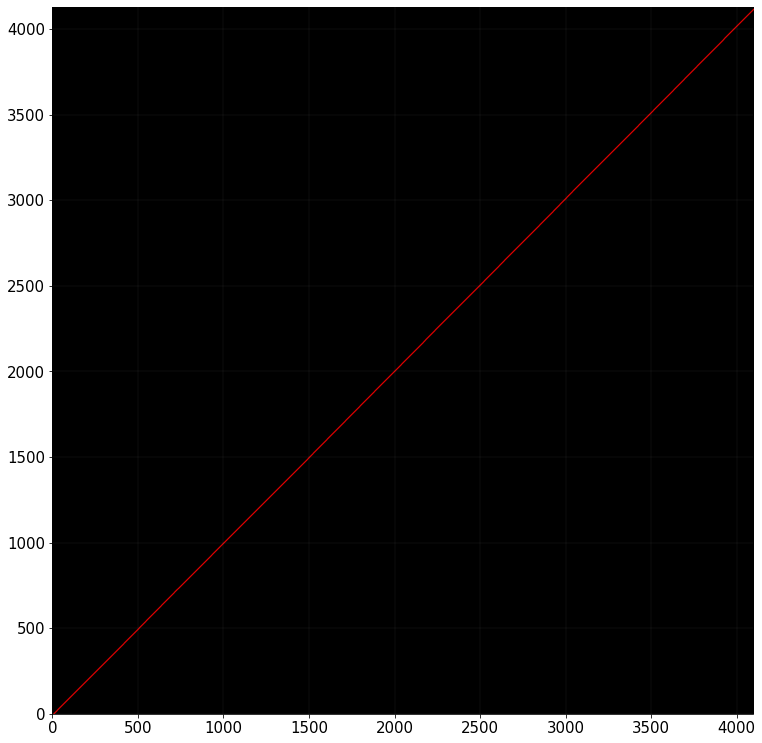

In [69]:
# Reading image
font = cv2.FONT_HERSHEY_COMPLEX
img2 = cv2.imread('./outputs/images/img01.jpeg', cv2.IMREAD_COLOR)
  
# Reading same image in another 
# variable and converting to gray scale.
img = cv2.imread('./outputs/images/img01.jpeg', cv2.IMREAD_GRAYSCALE)
  
# Converting image to a binary image
# ( black and white only image).
_, threshold = cv2.threshold(img, 110, 255, cv2.THRESH_BINARY)
  
# Detecting contours in image.
contours, _= cv2.findContours(threshold, cv2.RETR_TREE,
                               cv2.CHAIN_APPROX_SIMPLE)

# Going through every contours found in the image.
for cnt in contours :
  
    approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
  
    # draws boundary of contours.
    cv2.drawContours(img2, [approx], 0, (255, 0, 0), 5) 
    
#     # Used to flatted the array containing
#     # the co-ordinates of the vertices.
#     n = approx.ravel() 
#     i = 0
    
#     for j in n :
#         if(i % 2 == 0):
#             x = n[i]
#             y = n[i + 1]
  
#             # String containing the co-ordinates.
#             string = str(x) + " " + str(y) 
  
#             if(i == 0):
#                 # text on topmost co-ordinate.
#                 cv2.putText(img2, "Arrow tip", (x, y),
#                                 font, 0.5, (255, 0, 0)) 
#             else:
#                 # text on remaining co-ordinates.
#                 cv2.putText(img2, string, (x, y), 
#                           font, 0.5, (0, 255, 0)) 
#         i = i + 1

# for contour in contours:
#     x, y, _, _ = cv2.boundingRect(contour)
#     print(x, " ", y)

fig00, ax00 = plt.subplots(1,1, figsize=(13, 13))
im00 = ax00.imshow(img2, origin='lower')

# collect arrays in dictionary
savedict = {'R' : img2[:,:,0], 
            'G' : img2[:,:,1],
            'B' : img2[:,:,2],
            'event_synctimes' : event_synctimes,
            'lfp_synctimes' : lfp_synctimes
           }

sio.savemat('./outputs/mat/img2.mat', savedict)



# # Reading image
# font = cv2.FONT_HERSHEY_COMPLEX
# img2 = cv2.imread('test.jpeg', cv2.IMREAD_COLOR)
# # sio.savemat("img2.mat", img2)

# # collect arrays in dictionary
# savedict = {'R' : img2[:,:,0], 
#             'G' : img2[:,:,1],
#             'B' : img2[:,:,2]
#            }

# save to disk
# sio.savemat('./outputs/mat/img2.mat', savedict)

# cv2.imwrite('./outputs/images/img01.jpeg', img01)
# test00 = cv2.imread('./outputs/images/img01.jpeg', cv2.IMREAD_GRAYSCALE)
# test00.shape

In [71]:
from sklearn import linear_model

# get coordinates (x,y)
xy_coords = np.flip(np.column_stack(np.where(img01 > 0)), axis=1)
X = xy_coords[:,0].reshape(-1,1)
y = xy_coords[:,1].T
print(xy_coords[0:9, :])

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor(base_estimator=linear_model.LinearRegression(fit_intercept=True))
ransac.fit(X, y)

[[10  0]
 [11  1]
 [12  2]
 [13  3]
 [14  4]
 [15  5]
 [16  6]
 [17  7]
 [18  8]]


In [76]:
ransac.estimator_.intercept_

-12.256791677189085

In [75]:
flag_plot = 0
if (flag_plot):
    
    # Fit line using all data
    lr = linear_model.LinearRegression()
    lr.fit(X, y)

    
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    # Predict data of estimated models
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y = lr.predict(line_X)
    line_y_ransac = ransac.predict(line_X)

    # Compare estimated coefficients
    print("Estimated coefficients (true, linear regression, RANSAC):")
    print(coef, lr.coef_, ransac.estimator_.coef_)

    lw = 2
    plt.scatter(
        X[inlier_mask], y[inlier_mask], color="green", marker=".", label="Inliers"
    )
    plt.scatter(
        X[outlier_mask], y[outlier_mask], color="red", marker=".", label="Outliers"
    )
    # plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
    # plt.plot(
    #     line_X,
    #     line_y_ransac,
    #     color="cornflowerblue",
    #     linewidth=lw,
    #     label="RANSAC regressor",
    # )
    plt.legend(loc="lower right")
    plt.xlabel("Input")
    plt.ylabel("Response")
    plt.show()

In [66]:
ransac.estimator_.coef_




array([1.00787922])

In [ ]:
flag_plot = 0
if flag_plot:
    time_range = [ 30000, 100000 ] 
    ind_lfp_synctimes = np.where(np.logical_and(lfp_synctimes>=time_range[0], lfp_synctimes<=time_range[1]))
    ind_event_synctimes= np.where(np.logical_and(event_synctimes>=time_range[0], event_synctimes<=time_range[1]))
    fig, ax = plt.subplots(1, 1, figsize=(30, 10), dpi=300)
    plt.plot(lfp_synctimes[ ind_lfp_synctimes ], 
             np.full( ( 1, len( ind_lfp_synctimes[0] ) ), 255 )[0],
             marker = 'o', color = 'blue', linestyle = 'none', markersize = 16 ) 
    plt.plot(event_synctimes[ ind_event_synctimes ], 
             np.full( ( 1, len( ind_event_synctimes[0] ) ), 255 )[0],
             marker = 'x', color = 'red', linestyle = 'none', mew = 4, markersize = 16 ) 
    plt.show()  
    
# need a way to check (a) if time is in UNIX time or ? AND (b) if UNIX time is in us, ms, or s.

flag_plot = 0
# Creating histogram
if flag_plot:
    fig, ax = plt.subplots(figsize=[8, 8], sharex = 'col', sharey = 'row')
    ax = plt.subplot(2, 1, 1)
    ax.hist(np.diff(event_synctimes), bins = range(0, 2000, 10))
    ax = plt.subplot(2, 1, 2)
    ax.hist(np.diff(lfp_synctimes), bins = range(0, 2000, 10))   
    
# 
flag_plot = 0
if flag_plot:
    time_range = [ 30000, 50000 ] 
    ind_lfp_synctimes = np.where(np.logical_and(lfp_synctimes>=time_range[0], lfp_synctimes<=time_range[1]))
    ind_event_synctimes= np.where(np.logical_and(event_synctimes>=time_range[0], event_synctimes<=time_range[1]))
    fig, ax = plt.subplots(1, 1, figsize=(30, 10), dpi=300)
    plt.plot(lfp_synctimes[ ind_lfp_synctimes ], 
             np.full( ( 1, len( ind_lfp_synctimes[0] ) ), 255 )[0],
             marker = 'o', color = 'blue', linestyle = 'none', markersize = 16 ) 
    plt.plot(event_synctimes[ ind_event_synctimes ], 
             np.full( ( 1, len( ind_event_synctimes[0] ) ), 255 )[0],
             marker = 'x', color = 'red', linestyle = 'none', mew = 4, markersize = 16 ) 
    plt.show()  
    
#
print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

subj, sess = subj_sess.split('_')
sync_f = os.path.join('/home1/cjmac/projects/time_cells', 'data', subj, sess, 'sync', 'sync_channel_micro.mat')

In [ ]:
# Find matching sync pulse pairs.
event_synctimes_adj, lfp_synctimes_adj = events_preproc.pair_sync_pulses(event_synctimes, 
                                                                         lfp_synctimes, 
                                                                         step=5, 
                                                                         max_shift=250, 
                                                                         max_slide=50, 
                                                                         ipi_thresh=2
                                                                        )
                                           

In [ ]:
# all_value = pd.DataFrame(events.value.tolist())
# # events.to_csv('./outputs/csv/events_all.csv')
# # events[events.key=='gameState'].to_csv('./outputs/csv/events_gameState.csv')
# # events_gs = events[events.key=='gameState' & all_value.stateName == 'InitTrial']
# events_gs = events[(events.key == 'gameState') & (all_value.stateName == 'InitTrial')]
# events_gs
events.loc[events.key == 'syncPulse'].to_csv('./outputs/csv/events_all_synctimes_U540.csv')
pd.DataFrame(lfp_synctimes).to_csv('./outputs/csv/lfp_synctimes_U540.csv')

In [ ]:
events.loc[events.key == 'syncPulse'].to_csv('./outputs/csv/events_all_synctimes_U540.csv')
pd.DataFrame(lfp_synctimes).to_csv('./outputs/csv/lfp_synctimes_U540.csv')
# pd.DataFrame(lfp_synctimes_adj).to_csv('./outputs/csv/lfp_synctimes_adj.csv')
# # pd.DataFrame(event_synctimes).to_csv('./outputs/csv/synctimes_events.csv')
# # pd.DataFrame(lfp_synctimes).to_csv('./outputs/csv/synctimes_lfp.csv')
# # pd.DataFrame(event_synctimes_adj).to_csv('./outputs/csv/synctimes_events_adj.csv')
# # pd.DataFrame(lfp_synctimes_adj).to_csv('./outputs/csv/synctimes_lfp_adj.csv')

# Perform the alignment.
alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                             lfp_synctimes_adj)

# Apply the alignment to all event times.
events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x))

# events.to_csv('./outputs/csv/events_all_adj.csv')
events.loc[events.key == 'syncPulse'].to_csv('./outputs/csv/events_all_adj_synctimes.csv')

# cjm addition
events['time'] = (events['time'] - events.at[0, 'time'])

flag_plot = 0     
if (flag_plot):

    # How did our alignment go?
    print('{} event sync pulses'.format(len(event_synctimes_adj)))
    print('{} LFP sync pulses identified'.format(len(lfp_synctimes_adj)))
    print('\n--------------------\nAlignment parameters\n--------------------')
    for k, v in alignment.items():
        print('{}: {}'.format(k, v))

    plt.close()
    fig, ax = plt.subplots(1, 3, figsize=(16, 6), dpi=300)
    ax = np.ravel(ax)

    min_syncs = np.min((len(event_synctimes_adj), len(lfp_synctimes_adj)))
    start = 0
    stop = None

    i = 0
    ax[i].scatter(np.diff(event_synctimes_adj), np.diff(lfp_synctimes_adj))
    ax[i].set_xlabel('$Event_{IPI}$', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('$LFP_{IPI}$', fontsize=font['label'], labelpad=8)
    ax[i].set_title('Inter-pulse interval correlation', fontsize=font['fig'], y=1.05)

    i = 1
    ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
    ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
    ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
    ax[i].set_title('$LFP_{IPI} - Event_{IPI}$', fontsize=font['fig'], y=1.05)

    i = 2
    ax[i].plot(lfp_synctimes_adj[start:stop] - event_synctimes_adj[start:stop])
    ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
    ax[i].set_title('LFP - Event synctimes', fontsize=font['fig'], y=1.05)

    for i in range(len(ax)):
        ax[i].tick_params(axis='both', which='major', labelsize=font['tick'])
    fig.tight_layout()    

    event_synctimes = events.loc[events['key']=='syncPulse', 'time'].values
    event_pulse_inds = (np.array([x for x in (event_synctimes-lfp_timestamps[0]) * (sr/1e3) 
                                  if x<len(lfp_timestamps)])).astype(np.int64)
    event_pulse_startinds_train = np.zeros(len(lfp_timestamps))
    event_pulse_startinds_train[event_pulse_inds] = 1

#     fig, ax = plot_trace2(TTL_up, spike_dat=event_pulse_startinds_train,
#                           start=300, duration=30, nwin=6, x_units='secs', sampling_rate=sr)


## Format events and spikes

In [ ]:
reload(events_preproc)
reload(events_proc)

events.value

In [ ]:
proc_events = True
proc_spikes = True
proj_dir = '/home1/cjmac/projects/time_cells'
subj_sess = 'U555_ses0'
run_all = True
save_output = True
overwrite = True
verbose = False

start_time = time()
warnings.filterwarnings('ignore')

if proc_events:
    # Load events and event times.
    print('Processing events data.', end='\n\n')
    events = events_preproc.format_events(events=events,
                                          noisy_trials=[],
                                          remove_incomplete_trials=True,
                                          remove_noisy_trials=False,
                                          remove_paused_trials=False,
                                          overwrite=overwrite,
                                          save_output=save_output,
                                          proj_dir=proj_dir,
                                          verbose=verbose)

In [ ]:
events = events_proc.load_events(subj_sess,
                             proj_dir=proj_dir,
                             overwrite=overwrite,
                             verbose=verbose,
                             run_all=run_all)

In [ ]:
if save_output:
events_proc.save_events(events,
                        overwrite=overwrite,
                        verbose=verbose)

if proc_spikes:
    # Load spikes.
    print('Processing spikes data.', end='\n\n')
    spikes = spike_preproc.format_spikes(subj_sess,
                                         conv_factor='infer',
                                         fr_thresh=0.1,
                                         overwrite=True,
                                         save_output=True,
                                         split_files=True,
                                         verbose=verbose)

# warnings.resetwarnings()
# print('Done in {:.2f} s'.format(time() - start_time))

savefile = False
overwrite = False

event_spikes = time_bin_analysis.load_event_spikes(subj_sess, overwrite=overwrite)
if savefile:
    time_bin_analysis.save_event_spikes(event_spikes, overwrite=overwrite)

savefile = True
overwrite = True

event_spikes = time_bin_analysis.load_event_spikes(subj_sess, overwrite=overwrite)
if savefile:
    time_bin_analysis.save_event_spikes(event_spikes, overwrite=overwrite)

In [ ]:
def model_unit_fr_parallel(subj_sess_neuron):
    import sys
    import os
    from time import sleep
    import numpy as np
    sys.path.append('/home1/cjmac/code/projects')
    from time_cells.time_bin_analysis import model_unit_fr
    # Take a nap.
    if False:
        sleep_secs = int(1800 * np.random.rand())
        sleep(sleep_secs)
    try:
        subj_sess, chan, unit = subj_sess_neuron.split('-')
        neuron = '{}-{}'.format(chan, unit)
        output = model_unit_fr(subj_sess,
                               neuron,
                               model='ols',
                               n_perm=1000,
                               overwrite=True,
                               save_output=True)
    except:
        err = sys.exc_info()
        errf = '/home1/cjmac/logs/TryExceptError-model_unit_fr_parallel-{}'.format(subj_sess_neuron)
        os.system('touch {}'.format(errf))
        with open(errf, 'w') as f:
            f.write(str(err) + '\n')
    
    return None

# from importlib import reload
# flag_reload = 1
# if flag_reload:
#     reload( time_bin_analysis )

start_time = time()

# Load event_spikes and get the names of each neuron.
proj_dir = '/home1/cjmac/projects/time_cells'

# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
sessions = np.delete(sessions, 0)
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

subj_sess_neurons = []
for subj_sess in sessions:
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    for neuron in event_spikes.column_map['neurons']:
        subj_sess_neuron = '{}-{}'.format(subj_sess, neuron)
        #output_f = op.join(proj_dir, 'analysis', 'behav_glms', '{}-glm_results.pkl'.format(subj_sess_neuron))
        output_f = op.join(proj_dir, 'analysis', 'unit_to_behav', '{}-ols-time_bin-model_pairs.pkl'.format(subj_sess_neuron))
        print(output_f)
        if not op.exists(output_f):
            subj_sess_neurons.append(subj_sess_neuron)
    print('{} neurons'.format(len(subj_sess_neurons)))

# cjm change
subj_sess_neurons = ['U554_ses0-46-1']

# # cjm change
if False:
    subj_sess_neurons = [which_neuron for which_neuron in subj_sess_neurons if which_neuron in [ 'U554_ses0-46-1' ] ]

## Section to understand how OLS fitting was done in time_bin_analysis.py

In [ ]:
df = event_spikes.event_spikes.query("(gameState=='{}')".format('Retrieval')).copy()
neuron = '46-1'
keep_cols = ['trial', 'gameState', 'time_step', 'maze_region', 'head_direc', 'is_moving', 
             'base_in_view', 'gold_in_view', 'dig_performed', neuron]
df = df[keep_cols]
dummys = ['is_moving', 'base_in_view', 'gold_in_view', 'dig_performed']
df[dummys] = df[dummys].fillna(0)
df.to_csv('mdl_46-1.csv')
regress_trial = False
trial_term = ' + C(trial)' if regress_trial else ''
formulas = od([])
formulas['full']          = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_subtime']  = "Q('{}') ~ 1                + C(maze_region) + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_subplace'] = "Q('{}') ~ 1 + C(time_step)                  + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_subhd']    = "Q('{}') ~ 1 + C(time_step) + C(maze_region)                 + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_submvmt']  = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc)             + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_subbiv']   = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving                + dig_performed{}".format(neuron, trial_term)
formulas['full_subdig']   = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving + base_in_view                {}".format(neuron, trial_term)
mod_names = list(formulas.keys())
df2 = df[['trial', 'gameState', 'maze_region', '46-1']].to_csv('mdl_place_46-1.csv')

## Section to organize spiking data into a table to determin the # spikes per maze segment.

In [ ]:
all_neurons = event_spikes.column_map.get('neurons')
which_neuron = all_neurons[5]
keep_cols = ['trial', 'gameState', 'time_step', 'maze_region', 'head_direc', 'is_moving', 
             'base_in_view', 'gold_in_view', 'dig_performed', which_neuron]
rows = {'gameState':'Encoding'}
df = get_df_subset(event_spikes.event_spikes.copy(), columns = keep_cols, rows = rows)
df

# df.insert(4, 'duration', df['stop_time']-df['start_time'])
# df = df.drop(columns=['start_time', 'stop_time'])

# Let's print the first entries
# in all the groups formed.
df_group = df.groupby(['maze_region']).sum()
df_group.insert(3, 'rate', df_group[which_cell]/df_group['duration']*1000)
df_group

In [ ]:
if True:
    reload(time_bin_analysis)

# Parallel processing
for subj_sess_neuron in subj_sess_neurons:
    _start_time = time()
    print(subj_sess_neuron)
    _ = model_unit_fr_parallel(subj_sess_neuron)
    print('{:.1f}s'.format(time() - start_time))

print('Done in {:.1f}s')

In [ ]:
# subj_sess_neurons = subj_sess_neurons[23]
subj_sess_neurons

In [ ]:
# import pickle

with open('U554_ses0-46-1-ols-time_bin-model_pairs.pkl', 'rb') as f:
    data = pickle.load(f)

# %cd /home1/cjmac/projects/time_cells/analysis/unit_to_behav

In [ ]:
data